Guidance on using this dataset: https://www.kaggle.com/code/acelevin/identifying-playing-cards

Download dataset from: https://www.kaggle.com/datasets/gunhcolab/object-detection-dataset-standard-52card-deck/data

In [1]:
import tensorflow as tf
import pickle
from PIL import Image
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2

In [2]:
#hyper parameters:
BATCH_SIZE = 32
NUM_EPOCHS = 20

### Model Architecture

In [3]:
class CardPredictor(tf.keras.Model):
    def __init__(self):
        super(CardPredictor, self).__init__()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        
        data_augmentation = tf.keras.models.Sequential([
                                tf.keras.layers.RandomRotation(0.1),
                                tf.keras.layers.RandomZoom(0.1),
                            ])
        
        self.architecture = [        
                tf.keras.layers.InputLayer((300, 300, 3)),
                data_augmentation,
                             
                tf.keras.layers.Conv2D(32, (3, 3)),       # Conv + ReLU
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.MaxPooling2D((2, 2)),

                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Conv2D(64, (3, 3)),       # Conv + ReLU
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.MaxPooling2D((2, 2)),

                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Conv2D(128, (3, 3)),       # Conv + ReLU
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.MaxPooling2D((2, 2)),
                
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Conv2D(256, (3, 3)),       # Conv + ReLU
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.MaxPooling2D((2, 2)),
                
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Conv2D(512, (3, 3)),       # Conv + ReLU
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.MaxPooling2D((2, 2)),

                tf.keras.layers.Flatten(),                                   # Flatten to vector
                
                tf.keras.layers.Dense(256, activation='relu'),               # Fully connected layer
                tf.keras.layers.Dropout(0.5),                                # Prevent overfitting
                tf.keras.layers.Dense(52, activation='softmax')
                ]
        
        
        self.sequential = tf.keras.Sequential(self.architecture, name="card_predictor")
        
    def call(self, x):
        """ Passes input image through the network. """
        return self.sequential(x)

    @staticmethod
    def loss_fn(labels, predictions): 
           """ Loss function for the model. """
           return tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

### Dataset Loading

In [4]:
with open('train.pkl', 'rb') as file:
    data = pickle.load(file)
    
new_data = {}
for key, inner_dict in data.items():
    img_path = inner_dict['img_path']
    value = inner_dict['class_label']
    new_data[img_path] = value

In [43]:
for key, value in new_data.items():
    if value == 3:
        print(key, value)
        break

imgs/single/405.png 3


In [5]:
dataset = tf.data.Dataset.from_tensor_slices((new_data.keys(), new_data.values()))

def load_train_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [300, 300])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

dataset = dataset.map(load_train_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_size = int(0.8 * len(dataset))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

2025-05-02 16:28:46.371758: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-02 16:28:46.371796: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-02 16:28:46.371801: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-02 16:28:46.371822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-02 16:28:46.371844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
# this cell it optional
# this checks that the dataset is balanced
import collections
v_counts = collections.Counter()
t_counts = collections.Counter()

for _, label in val_dataset:
    label = label.numpy().tolist() 
    v_counts.update(label)

for _, label in train_dataset:
    label = label.numpy().tolist() 
    t_counts.update(label)
    
print("Label counts in validation dataset:")
for i in range(52):
    print(f"Label {i}: {v_counts[i]}, {t_counts[i]}")

2025-05-02 16:46:38.341097: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Label counts in validation dataset:
Label 0: 17, 112
Label 1: 26, 109
Label 2: 28, 115
Label 3: 31, 105
Label 4: 30, 100
Label 5: 23, 106
Label 6: 27, 111
Label 7: 31, 105
Label 8: 31, 110
Label 9: 28, 110
Label 10: 31, 118
Label 11: 17, 105
Label 12: 31, 106
Label 13: 27, 111
Label 14: 28, 113
Label 15: 18, 99
Label 16: 17, 107
Label 17: 26, 104
Label 18: 28, 110
Label 19: 26, 107
Label 20: 30, 112
Label 21: 26, 106
Label 22: 32, 110
Label 23: 36, 104
Label 24: 27, 112
Label 25: 35, 111
Label 26: 23, 107
Label 27: 23, 104
Label 28: 29, 104
Label 29: 28, 100
Label 30: 20, 110
Label 31: 23, 108
Label 32: 26, 103
Label 33: 36, 103
Label 34: 27, 108
Label 35: 23, 111
Label 36: 15, 105
Label 37: 30, 109
Label 38: 29, 110
Label 39: 29, 99
Label 40: 21, 112
Label 41: 28, 103
Label 42: 25, 111
Label 43: 29, 107
Label 44: 34, 104
Label 45: 18, 98
Label 46: 27, 114
Label 47: 28, 113
Label 48: 23, 107
Label 49: 27, 108
Label 50: 33, 113
Label 51: 23, 111


2025-05-02 16:46:47.059836: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Model Loading and Training

In [131]:
model = CardPredictor()
model.build((None, 300, 300, 3))
model.load_weights("model_weights_e80_a88.weights.h5")

model.compile(optimizer=model.optimizer, loss=model.loss_fn, metrics=['accuracy'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted class: Q of club


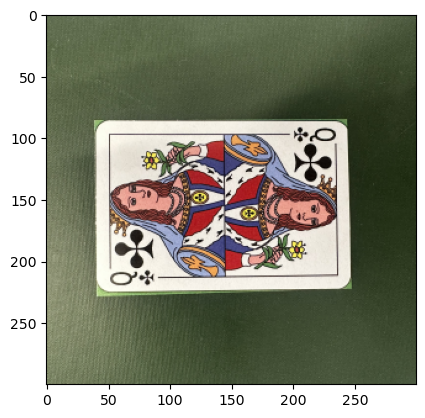

In [138]:
# THIS IS TO TEST THE MODEL ON THE DATASET
values = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
suits = ['club', 'diamond', 'heart', 'spade']
class_names = [f"{v} of {s}" for v in values for s in suits]

def center_crop_and_resize(image, target_size=(300, 300)):
    h, w = image.shape[:2]
    
    # Find the shorter dimension and crop to a centered square
    min_dim = min(h, w)
    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2
    cropped = image[start_y:start_y + min_dim, start_x:start_x + min_dim]

    # Resize to the target size (e.g., 300x300)
    resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
    return resized

image = tf.io.read_file('Q_of_C.jpg')
image = tf.image.decode_jpeg(image, channels=3)
image = center_crop_and_resize(image.numpy(), target_size=(300, 300))
image = tf.cast(image, tf.float32) / 255.0
    
image = tf.expand_dims(image, axis=0)
predictions = model.predict(image)
predicted_class = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class]
print(f"Predicted class: {predicted_class_name}")
plt.imshow(image[0])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
9 of diamond
9 of diamond


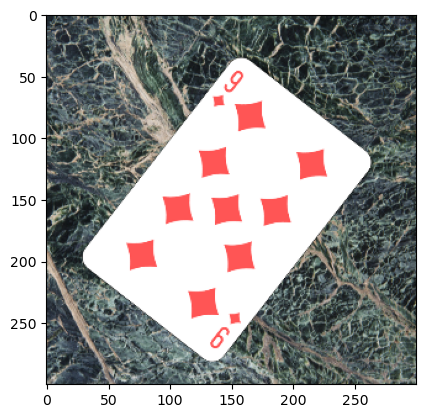

In [124]:
# THIS IS TO TEST THE MODEL ON THE DATASET
values = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
suits = ['club', 'diamond', 'heart', 'spade']
class_names = [f"{v} of {s}" for v in values for s in suits]

sample = train_dataset.take(1).as_numpy_iterator().next()

plt.imshow(sample[0][0])
print(class_names[np.argmax(model.predict(sample[0][0][tf.newaxis, ...]), axis=1)[0]])
print(class_names[sample[1][0]])

plt.show()

In [58]:
model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=NUM_EPOCHS, 
          verbose=1)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 60s 286ms/step - accuracy: 0.8804 - loss: 35237.7812 - val_accuracy: 0.8866 - val_loss: 36076.2734
Epoch 2/20


KeyboardInterrupt: 

In [24]:
model.save_weights('new_weights.weights.h5')

## Video capture and classification

In [139]:
def center_crop_and_resize(image, target_size=(300, 300)):
    h, w = image.shape[:2]
    
    # Find the shorter dimension and crop to a centered square
    min_dim = min(h, w)
    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2
    cropped = image[start_y:start_y + min_dim, start_x:start_x + min_dim]

    # Resize to the target size (e.g., 300x300)
    resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
    return resized

In [25]:
model = CardPredictor()
model.build((None, 300, 300, 3))
model.load_weights('model_weights.weights.h5')

/Users/RioVK/miniforge3/envs/cs1430/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Press 'c' to capture and classify a card.
Press 'q' to quit.
Capturing frame...


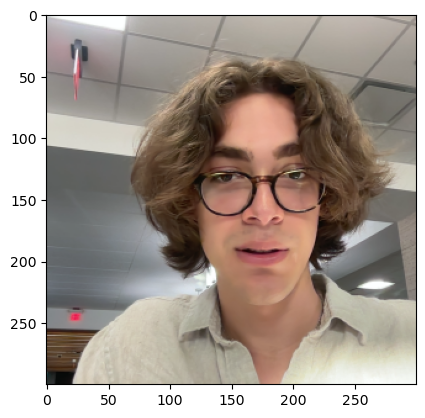

Prediction: tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]], shape=(1, 52), dtype=float32)
Exiting.
Releasing camera feed.
Destroying windows


In [141]:
values = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
suits = ['club', 'diamond', 'heart', 'spade']
class_names = [f"{v} of {s}" for v in values for s in suits]
# === Start camera ===
cam = cv2.VideoCapture(0)

if not cam.isOpened():
    print("Error: Could not open camera.")
    exit()

print("Press 'c' to capture and classify a card.")
print("Press 'q' to quit.")

while True:
    ret, frame = cam.read()
    if not ret:
        print("Error: Failed to read frame.")
        break

    # Show the camera feed
    cv2.imshow("Live Feed - Press 'c' to classify, 'q' to quit", frame)

    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        print("Exiting.")
        break
    elif key == ord('c'):
        print("Capturing frame...")

        # Preprocess the frame
        image = tf.convert_to_tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image = center_crop_and_resize(image.numpy(), target_size=(300, 300))
        plt.imshow(image)
        plt.show()
        image = tf.cast(image, tf.float32) / 255.0
        image = np.expand_dims(image, axis=0)

        # Predict
        pred = model(image, training=False)
        print("Prediction:", pred)
        predicted_class = tf.argmax(pred, axis=1).numpy()[0]
        # check dataset to fix the indexing here.
        class_name = class_names[predicted_class]

        # Overlay prediction and display result on the top right corner of the image. 
        display_frame = frame.copy()
        cv2.putText(display_frame, f"Prediction: {class_name}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow("Prediction", display_frame)
        cv2.waitKey(1500)  # Show prediction for 1.5 seconds

print("Releasing camera feed.")
cam.release()
print("Destroying windows")
cv2.destroyAllWindows()

In [51]:
for i in range(52):
    print("class:", i, class_names[i])

class: 0 2 of club
class: 1 2 of diamond
class: 2 2 of heart
class: 3 2 of spade
class: 4 3 of club
class: 5 3 of diamond
class: 6 3 of heart
class: 7 3 of spade
class: 8 4 of club
class: 9 4 of diamond
class: 10 4 of heart
class: 11 4 of spade
class: 12 5 of club
class: 13 5 of diamond
class: 14 5 of heart
class: 15 5 of spade
class: 16 6 of club
class: 17 6 of diamond
class: 18 6 of heart
class: 19 6 of spade
class: 20 7 of club
class: 21 7 of diamond
class: 22 7 of heart
class: 23 7 of spade
class: 24 8 of club
class: 25 8 of diamond
class: 26 8 of heart
class: 27 8 of spade
class: 28 9 of club
class: 29 9 of diamond
class: 30 9 of heart
class: 31 9 of spade
class: 32 10 of club
class: 33 10 of diamond
class: 34 10 of heart
class: 35 10 of spade
class: 36 J of club
class: 37 J of diamond
class: 38 J of heart
class: 39 J of spade
class: 40 Q of club
class: 41 Q of diamond
class: 42 Q of heart
class: 43 Q of spade
class: 44 K of club
class: 45 K of diamond
class: 46 K of heart
class: 

15


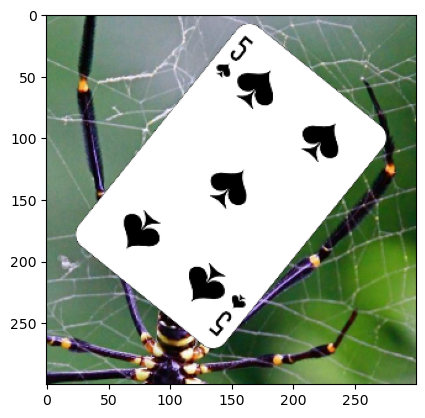

In [66]:
batch = val_dataset.take(1).as_numpy_iterator().next()
img = batch[0][0]
print(batch[1][0])
plt.imshow(img)
plt.show()

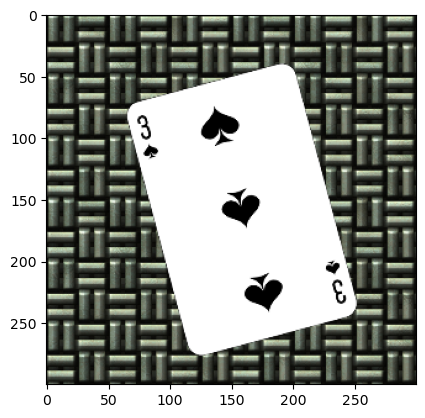

Prediction: tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0.]], shape=(1, 52), dtype=float32)
True label: 7


In [102]:
path = 'imgs/single/1013.png'

image = tf.io.read_file(path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [300, 300])
image = tf.cast(image, tf.float32) / 255.0
plt.imshow(image)
plt.show()

image = np.expand_dims(image, axis=0)
pred = model(image, training=False)

print("Prediction:", pred)
print("True label:", new_data[path])